# Compact Orthogonal Distance Regression

### Notebook settings

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# Configure plots
%config InlineBackend.figure_formats = 'svg'
%matplotlib inline

In [3]:
# Add src to path to load modules from the package
import sys

sys.path.append("../src")

### Preview dataframe

In [4]:
from sft.data import load_df  # type: ignore

# Load and preview the full dataset
load_df("df_with_fracture_toughness_final_incl_bendingstiffness_final3.pkl").head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,exp_id,date,datetime_x,fieldsite,slope_incl,h_wl_notch,...,GIc_manual_default_min_error,GIIc_manual_default_min_error,Gc_manual_default_min_error,GIIG_manual_default_min_error,slope_incl_min_error,surface_lineload_min_error,GIc_video_seriesopt_min_error,GIIc_video_seriesopt_min_error,Gc_video_seriesopt_min_error,GIIG_video_seriesopt_min_error
0,0,0,0,0,2023_02_15_1,2023-02-15,2023-02-15,2,0.0+/-2.0,13.5,...,0.51+/-0.05,0.0089+/-0.0028,0.51+/-0.06,0.017+/-0.005,0.0+/-2.0,0.000454+/-0.000005,0.283+/-0.013,0.0140+/-0.0018,0.297+/-0.012,0.047+/-0.007
1,1,1,1,1,2023_02_15_2,2023-02-15,2023-02-15,2,-46.0+/-2.0,12.5,...,0.35+/-0.08,0.350+/-0.032,0.70+/-0.09,0.50+/-0.06,-46.0+/-2.0,0.000889+/-0.000009,0.27+/-0.05,0.253+/-0.006,0.52+/-0.05,0.48+/-0.05
2,2,2,2,2,2023_02_15_3,2023-02-15,2023-02-15,2,-56.0+/-2.0,13.0,...,0.19+/-0.07,0.51+/-0.05,0.70+/-0.09,0.73+/-0.07,-56.0+/-2.0,0.000889+/-0.000009,0.32+/-0.09,0.471+/-0.018,0.80+/-0.10,0.59+/-0.06
3,3,3,3,3,2023_02_15_4,2023-02-15,2023-02-15,2,-36.0+/-2.0,13.0,...,0.36+/-0.06,0.213+/-0.021,0.57+/-0.07,0.37+/-0.05,-36.0+/-2.0,0.000889+/-0.000009,0.37+/-0.05,0.205+/-0.005,0.57+/-0.05,0.357+/-0.034
4,4,4,4,4,2023_02_15_5,2023-02-15,2023-02-15,2,-25.0+/-2.0,12.5,...,0.34+/-0.05,0.097+/-0.012,0.44+/-0.05,0.224+/-0.034,-25.0+/-2.0,0.000889+/-0.000009,0.175+/-0.022,0.062+/-0.004,0.237+/-0.019,0.260+/-0.035


### Get only the data relevant for fits

In [5]:
from sft.prepare import build_fracture_toughness_df  # type: ignore

df = build_fracture_toughness_df(
    file="df_with_fracture_toughness_final_incl_bendingstiffness_final3.pkl",
    date_ranges={
        # "series": "date range"
        "1": (None, "2023-02-16"),
        "2": ("2023-02-27", "2023-03-03"),
        "3": ("2023-03-06", "2023-03-08"),
    },
    data_cols={
        # "source": ("GIc_col", "GIIc_col")
        "manual": (
            "GIc_manual_default_min_error",
            "GIIc_manual_default_min_error",
        ),
        "video": (
            "GIc_video_seriesopt_min_error",
            "GIIc_video_seriesopt_min_error",
        ),
    },
)

In [6]:
df

GIc             GIIc
source series                                
manual 1         0.51+/-0.05  0.0089+/-0.0028
       1         0.35+/-0.08    0.350+/-0.032
       1         0.19+/-0.07      0.51+/-0.05
       1         0.36+/-0.06    0.213+/-0.021
       1         0.34+/-0.05    0.097+/-0.012
...                      ...              ...
video  3       0.237+/-0.034    0.126+/-0.004
       3         0.33+/-0.06    0.272+/-0.013
       3       0.461+/-0.030  0.0533+/-0.0028
       3       0.347+/-0.025  0.0348+/-0.0023
       3         1.24+/-0.30      1.36+/-0.14

[240 rows x 2 columns]

### Filter outliers

In [7]:
from sft.prepare import filter_by_gc_threshold  # type: ignore

df = filter_by_gc_threshold(
    df,
    source="manual",
    gc_max=2.0,
)

df = filter_by_gc_threshold(
    df,
    source="video",
    gc_max=1.0,
)

In [17]:
len(df)

235

### Plot data

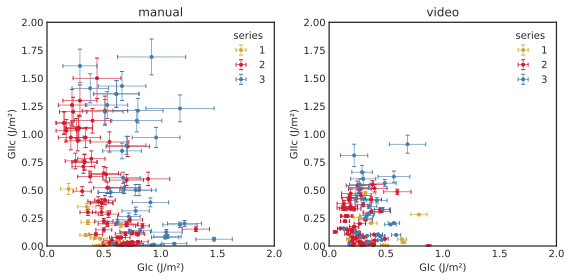

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp

sources = sorted(df.index.get_level_values("source").unique())
series_list = sorted(df.index.get_level_values("series").unique())
palette = [
    "#d3a836",
    "#ce1b30",
    "#447cab",
    "#89c9d9",
    "#77664c",
    "#c99076",
    "#69a0c5",
    "#2d5a7d",
]
colors = {s: palette[i % len(palette)] for i, s in enumerate(series_list)}
limits = (0, 2)

with plt.style.context("seaborn-v0_8-white"):
    fig, axes = plt.subplots(1, len(sources), figsize=(4 * len(sources), 4))
    axes = np.atleast_1d(axes)
    for ax, src in zip(axes, sources):
        for srs in series_list:
            sub = df.loc[(src, srs)]
            x, xerr = unp.nominal_values(sub["GIc"]), unp.std_devs(sub["GIc"])
            y, yerr = unp.nominal_values(sub["GIIc"]), unp.std_devs(sub["GIIc"])
            ax.errorbar(
                x,
                y,
                xerr=xerr,
                yerr=yerr,
                fmt="o",
                ms=3,
                elinewidth=0.6,
                capsize=2,
                color=colors[srs],
                label=srs,
            )
        ax.set(
            title=src,
            xlabel="GIc (J/m²)",
            ylabel="GIIc (J/m²)",
            xlim=limits,
            ylim=limits,
        )
        ax.legend(title="series")

    plt.tight_layout()


In [16]:
from sft.my_odr import odr

odr(df, source="manual")  # ndof should be 113

VARIABLE   VALUE   DESCRIPTION
---------------------------------------------------------------------
GIc_1      0.484   Mode I fracture toughness
GIIc_1     0.685   Mode II fracture toughness
GIc_2      0.664   Mode I fracture toughness
GIIc_2     1.368   Mode II fracture toughness
GIc_3      0.854   Mode I fracture toughness
GIIc_3     2.672   Mode II fracture toughness
n           0.70   Interaction-law exponent
m           0.90   Interaction-law exponent
---------------------------------------------------------------------
chi2       2.367   Reduced chi^2 per DOF (goodness of fit)
p-value    0.000   p-value (statistically significant if below 0.05)
R2         0.297   R-squared (not valid for nonlinear regression)



{'params': array([0.48375419, 0.68498223, 0.66382843, 1.36780929, 0.85433537,
        2.67190009, 0.7       , 0.9       ]),
 'stddev': array([0.02549705, 0.18156003, 0.01830986, 0.0994035 , 0.03995416,
        0.64051207, 0.        , 0.        ]),
 'reduced_chi_squared': 2.3671455227116254,
 'chi_squared': 267.4874440667903,
 'ndof': 113.00000000015912,
 'p_value': 1.5006191026617428e-14,
 'R_squared': 0.29698746111652496,
 'final': <scipy.odr._odrpack.Output at 0x17fdb2030>}

In [15]:
import logging
from sft.my_odr import odr

logging.basicConfig(level=logging.DEBUG)
odr(df, source="video", log_level=logging.DEBUG, log_file="odr_debug.log")

VARIABLE   VALUE   DESCRIPTION
---------------------------------------------------------------------
GIc_1      0.365   Mode I fracture toughness
GIIc_1     0.680   Mode II fracture toughness
GIc_2      0.279   Mode I fracture toughness
GIIc_2     0.607   Mode II fracture toughness
GIc_3      0.590   Mode I fracture toughness
GIIc_3     2.928   Mode II fracture toughness
n           0.50   Interaction-law exponent
m           0.70   Interaction-law exponent
---------------------------------------------------------------------
chi2       23.957   Reduced chi^2 per DOF (goodness of fit)
p-value    0.000   p-value (statistically significant if below 0.05)
R2         0.040   R-squared (not valid for nonlinear regression)



{'params': array([0.36458623, 0.68035749, 0.27910762, 0.6069431 , 0.59033927,
        2.92764165, 0.5       , 0.7       ]),
 'stddev': array([0.02536493, 0.99501926, 0.01478147, 0.25239492, 0.07220412,
        4.62108728, 0.        , 0.        ]),
 'reduced_chi_squared': 23.9571175364105,
 'chi_squared': 8581.204100994153,
 'ndof': 358.19017408719014,
 'p_value': 0.0,
 'R_squared': 0.040068729833927286,
 'final': <scipy.odr._odrpack.Output at 0x33b9820c0>}

In [13]:
from sft.my_odr import param_jacobian, residual

beta = [1, 2, 3, 4, 5, 6, 7, 8]
x = [(1, 1, 1, 4, 5), (2, 2, 2, 4, 5)]
series_idx = [0, 1, 2, 2, 2]

param_jacobian(beta, x, series_idx)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.01916409,  0.02609909,  0.00441107, -0.        ],
       [-0.        ,  0.00993154,  0.01496319,  0.0060223 ,  0.00278458]])

In [11]:
sdf = df.xs("video", level="source")
series_labels = sdf.index.get_level_values("series")
sorted(series_labels.unique()), len(sdf)

(['1', '2', '3'], 116)

In [12]:
np.maximum([1, 2, 3], 1e-6)

array([1., 2., 3.])

In [13]:
Gi = unp.nominal_values(df["GIc"].to_numpy())
Gii = unp.nominal_values(df["GIIc"].to_numpy())
Gierr = unp.std_devs(df["GIc"].to_numpy())
Giierr = unp.std_devs(df["GIIc"].to_numpy())
bad = ~np.isfinite(Gi) | ~np.isfinite(Gii) | ~np.isfinite(Gierr) | ~np.isfinite(Giierr)
bad_idx = np.where(bad)[0]
bad_idx, np.sum(bad)

(array([], dtype=int64), 0)

In [ ]:
def softplus(z):
    """Smoothly map to (0, inf)."""
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)


def smooth_violation(x, lo, hi, k=1e2):
    """≈ 0 inside [lo, hi]; grows smoothly outside; scales with k."""
    return softplus(k * (lo - x)) + softplus(k * (x - hi))

In [ ]:
GIc = np.array([1, 1, 1])

smooth_violation(GIc, 0, 3, k=1e3)

array([0., 0., 0.])

In [15]:
import numpy as np
from uncertainties import unumpy as unp

src = "manual"  # change as needed
sdf = df.xs(src, level="source")

gi = unp.nominal_values(sdf["GIc"].to_numpy())
gii = unp.nominal_values(sdf["GIIc"].to_numpy())

neg_mask = (gi < 0) | (gii < 0)
print("any negative:", bool(np.any(neg_mask)))
print("count GIc<0:", int(np.sum(gi < 0)), "min GIc:", float(np.nanmin(gi)))
print("count GIIc<0:", int(np.sum(gii < 0)), "min GIIc:", float(np.nanmin(gii)))
sdf_neg = sdf[neg_mask]
sdf_neg.head()

any negative: False
count GIc<0: 0 min GIc: 0.15
count GIIc<0: 0 min GIIc: 0.0004


,GIc,GIIc
series,,


In [16]:
gi_sd = unp.std_devs(sdf["GIc"].to_numpy())
gii_sd = unp.std_devs(sdf["GIIc"].to_numpy())

cross0_gi = (gi - 3 * gi_sd) <= 0
cross0_gii = (gii - 3 * gii_sd) <= 0
print("GIc  3σ crosses 0:", int(np.sum(cross0_gi)))
print("GIIc 3σ crosses 0:", int(np.sum(cross0_gii)))

GIc  3σ crosses 0: 22
GIIc 3σ crosses 0: 17


In [17]:
for series in sdf.index.get_level_values("series").unique():
    d = df.xs(series, level="series")
    gi_s = unp.nominal_values(d["GIc"].to_numpy())
    gii_s = unp.nominal_values(d["GIIc"].to_numpy())
    print(
        series, "min GIc:", float(np.nanmin(gi_s)), "min GIIc:", float(np.nanmin(gii_s))
    )

1 min GIc: 0.175 min GIIc: 8e-05
2 min GIc: 0.054 min GIIc: 0.0
3 min GIc: 0.129 min GIIc: 0.007


In [ ]:
beta8 = [
    0.36458623,
    0.68035749,
    0.27910762,
    0.6069431,
    0.59033927,
    2.92764165,
    0.5,
    0.7,
]
Gi = unp.nominal_values(df.xs("video", level="source")["GIc"].to_numpy())
Gii = unp.nominal_values(df.xs("video", level="source")["GIIc"].to_numpy())
series_idx = (
    df.xs("video", level="source").index.get_level_values("series").astype(int) - 1
)


def sse_vs_giic3(beta8, Gi, Gii, series_idx, grid):
    b = beta8.copy()
    sse = []
    for val in grid:
        b[5] = val  # GIIc_3 in [GIc_1,GIIc_1,GIc_2,GIIc_2,GIc_3,GIIc_3,n,m]
        r = residual(b, (Gi, Gii), series_idx)
        sse.append(np.nansum(r**2))
    return np.array(sse)


grid = np.linspace(0.2, 6.0, 50)
sse = sse_vs_giic3(beta8, Gi, Gii, series_idx, grid)
print("monotone decreasing:", np.all(np.diff(sse) < 0))

monotone decreasing: False


In [34]:
Jp = param_jacobian(beta8, (Gi, Gii), series_idx)
grad = np.nansum(2 * residual(beta8, (Gi, Gii), series_idx) * Jp[5])  # index 5 = GIIc_3
print("dSSE/dGIIc_3 =", grad)

dSSE/dGIIc_3 = -0.459370665989883


In [35]:
grid = np.linspace(0.2, 6.0, 200)
sse = sse_vs_giic3(beta8, Gi, Gii, series_idx, grid)
giic3_star = grid[np.nanargmin(sse)]
float(giic3_star), float(np.nanmin(sse))

(2.9105527638190956, 170.827614544513)

In [ ]:
mask3 = series_idx == 2


def sse_series3(beta8, val):
    b = beta8.copy()
    b[5] = val
    r = residual(b, (Gi, Gii), series_idx)
    return np.nansum(r[mask3] ** 2)


sse3 = np.array([sse_series3(beta8, v) for v in grid])
grid[np.nanargmin(sse3)], np.nanmin(sse3)

(2.9105527638190956, 9.228751413890485)

In [37]:
r = residual(beta8, (Gi, Gii), series_idx)
float(np.nanmean(r[mask3]))

0.17929893561030194